In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm
import pandas as pd

In [4]:
%matplotlib notebook
np.set_printoptions(precision=4, linewidth=500, threshold=500, suppress=True)

In [5]:
import sys
sys.path.append('../..')

In [7]:
from models.reconstruction.var_estimators import RRVarSolver, RNCVarSolver, LFPVarSolver
from models.reconstruction.multivariate import MultivariateGraphSignalReconstructor, get_y_and_s

from graph.graphs import ProductGraph
from graph.filters import UnivariateFilterFunction

from utils.linalg import vec, ten
from utils.kronecker import KroneckerDiag

from algorithms.query import select_Q_active, select_Q_passive

# Experiment 1


In [8]:
N1 = 40
N2 = 50
N = N1 * N2

graph = ProductGraph.lattice(N1, N2)
signal = np.random.rand(N2, N1)
signal[np.random.randint(0, 2, (N2, N1)).astype(bool)] = np.nan
gamma = 0.02

Y, S = get_y_and_s(signal)
filter_function = UnivariateFilterFunction.diffusion(beta=1)
G = filter_function(graph.lam)
n_neighbours = graph.A.sum(0)

X = np.array([np.ones(N),
              vec(1 - S),
              graph.U @ KroneckerDiag(G) @ graph.U.T @ vec(1 - S),
              (graph.U ** 2) @ vec(G),
              (graph.U ** 2) @ vec(G ** 2),
              n_neighbours,
              graph.U @ KroneckerDiag(G) @ graph.U.T @ n_neighbours
              ]).T

X[:, 1:] = X[:, 1:] / X[:, 1:].std(axis=0)
X[:, 1:] = X[:, 1:] - X[:, 1:].mean(axis=0)

In [10]:
def estimate_omega_cgm():
    
    om = np.zeros((N2, N1))
    solver = MultivariateGraphSignalReconstructor(signal, graph, filter_function, gamma)
    
    for n in tqdm(range(N2), leave=False):
        for t in range(N1):
    
            om[n, t] = solver.query((n, t))
            
    return om

In [11]:
def compute_exp_1(lam_rr, lam_rnc, lam_lfp, n_q_steps=40, n_trials=50):
    
    results = {name: np.zeros((n_q_steps, n_trials)) for name in ['rr_active', 'rr_passive', 'rnc_active', 'rnc_passive', 'lfp_active', 'lfp_passive']}
    
    Omega = estimate_omega_cgm()
    
    for i, n in enumerate(tqdm((2 * np.logspace(0.5, 3, n_q_steps) - 1).astype(int))):

        for t in range(n_trials):

            Q_active = select_Q_active(X, n, shape=Omega.shape)
            Q_passive = select_Q_passive(n, shape=Omega.shape)

            Omega_Q_active = Omega * Q_active.astype(int)
            Omega_Q_passive = Omega * Q_passive.astype(int)
            
            results['rr_active'][i, t] = RRVarSolver(Omega_Q=Omega_Q_active, Q=Q_active, X=X, lam=lam_rr).rmse(Omega)
            results['rr_passive'][i, t] = RRVarSolver(Omega_Q=Omega_Q_passive, Q=Q_passive, X=X, lam=lam_rr).rmse(Omega)
            
            results['rnc_active'][i, t] = RNCVarSolver(Omega_Q_active, Q_active, X, graph, filter_function, gamma, lam_rnc).rmse(Omega)
            results['rnc_passive'][i, t] = RNCVarSolver(Omega_Q_passive, Q_passive, X, graph, filter_function, gamma, lam_rnc).rmse(Omega)

            results['lfp_active'][i, t] = LFPVarSolver(Omega_Q_active, Q_active, X, graph, filter_function, lam_lfp).rmse(Omega)
            results['lfp_passive'][i, t] = LFPVarSolver(Omega_Q_passive, Q_passive, X, graph, filter_function, lam_lfp).rmse(Omega)
            
    return results
            
            
            

In [12]:
n_q_steps = 40
n_trials = 50
results = compute_exp_1(0.005, 0.005, 0.001, n_q_steps, n_trials)

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/home/ed/Dropbox/Ed/Documents/PhD/Thesis/Code/nd-graph-signals/notebooks/Performance Evaluations/../../algorithms/query.py:98: RuntimeWarning: Mean of empty slice.
  centroids[c] = data[labels == c].mean(0)
/home/ed/miniconda3/envs/p310/lib/python3.10/site-packages/numpy/core/_methods.py:181: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(


Labels unchanged ! Terminating k-means.


In [13]:
def plot_experiment1(results):
    
    fig, axes = plt.subplots(ncols=2, nrows=2, sharey='row', sharex=True, figsize=(15, 10))

    x = (2 * np.logspace(0.5, 3, n_q_steps)).astype(int)

    for solver in ['RR', 'RNC', 'LFP']:
        
        for i, (query_strategy, title) in enumerate(zip(['passive', 'active'], ['Random Queries', 'Representative Queries'])):

            y_1 = results[solver.lower() + '_' + query_strategy].mean(1)
            y_2 = results[solver.lower() + '_' + query_strategy].std(1) / n_trials ** 0.5
            
            axes[0, i].plot(x, y_1, label=solver, alpha=0.8)
            axes[1, i].plot(x[:-1], y_2[:-1], label=solver, alpha=0.8)
    
    axes[0, 0].set_ylim(2e-2, 1.5e0)
    
    for ax in axes.flatten():
        ax.set_yscale('log')
        ax.set_xscale('log')
        ax.grid(which='major')
        ax.grid(which='minor', alpha=0.1)
        ax.legend(fontsize='xx-large')
        
        
        ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
        ax.set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in ax.get_yticks()], fontsize='xx-large')
        
    axes[0, 0].set_title('Random Queries', fontsize='xx-large', pad=20)
    axes[0, 1].set_title('Representative Queries', fontsize='xx-large', pad=20)

    axes[0, 0].set_ylabel('Mean RMSE', fontsize='xx-large', labelpad=10)
    axes[1, 0].set_ylabel('Standard Error', fontsize='xx-large', labelpad=10)

    axes[1, 0].set_xlabel('Number of queries', fontsize='xx-large', labelpad=10)
    axes[1, 1].set_xlabel('Number of queries', fontsize='xx-large', labelpad=10)
    
    plt.tight_layout()
    

<IPython.core.display.Javascript object>


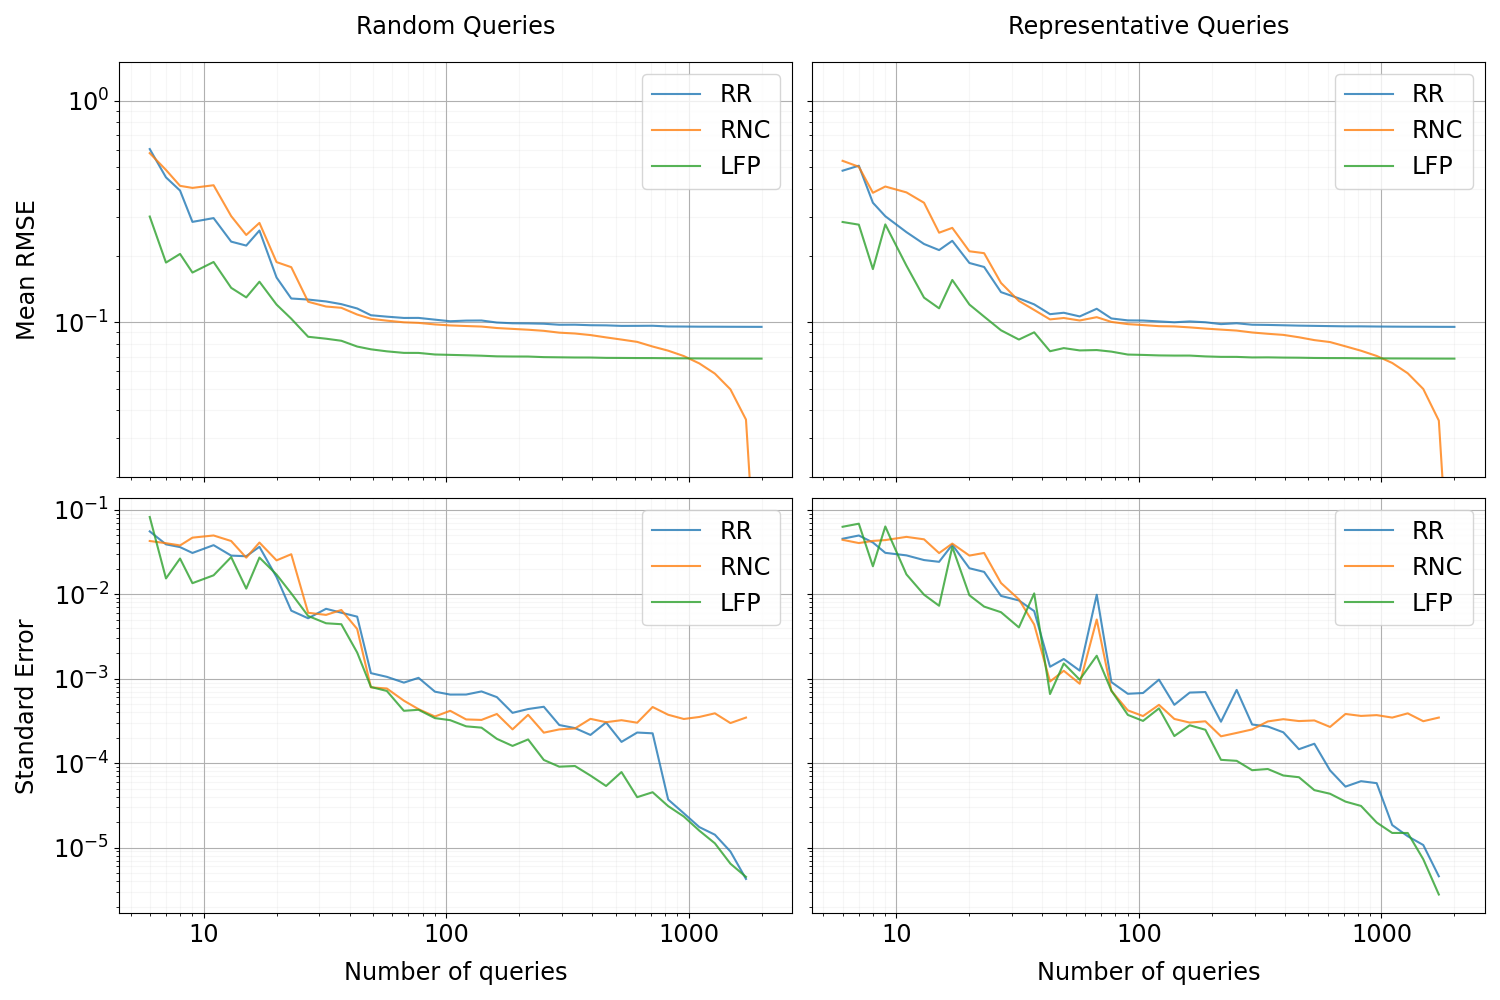

/tmp/ipykernel_8333/1453812649.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_8333/1453812649.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in ax.get_yticks()], fontsize='xx-large')


In [14]:
plot_experiment1(results)


<IPython.core.display.Javascript object>


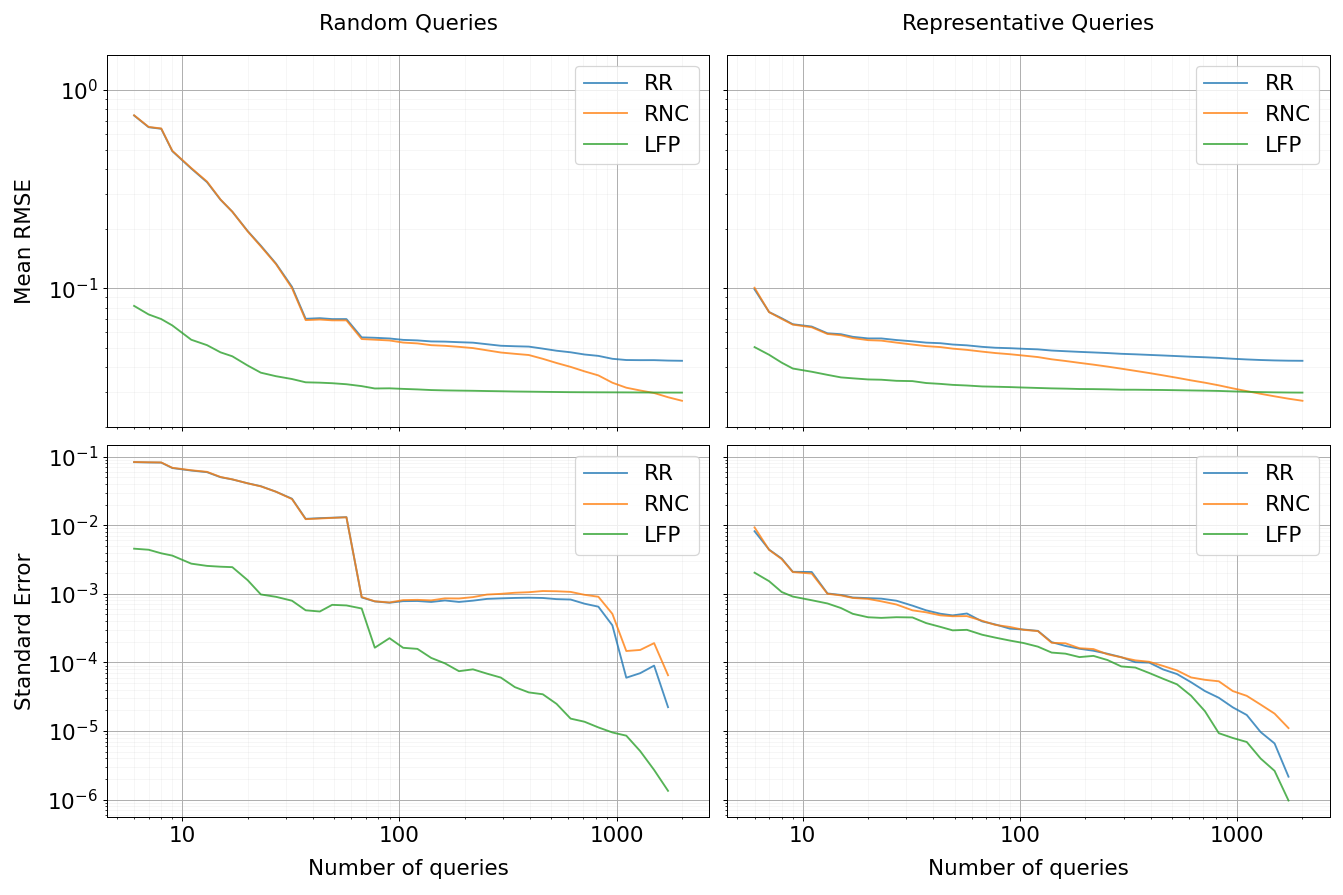

/tmp/ipykernel_7711/1453812649.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_7711/1453812649.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in ax.get_yticks()], fontsize='xx-large')


In [252]:
plot_experiment1(all_results[1])

plt.savefig('queries.pdf')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_7711/876301220.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_7711/876301220.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in ax.get_yticks()], fontsize='xx-large')


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_7711/876301220.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_7711/876301220.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in ax.get_yticks()], fontsize='xx-large')


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_7711/876301220.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_7711/876301220.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in ax.get_yticks()], fontsize='xx-large')


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_7711/876301220.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_7711/876301220.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in ax.get_yticks()], fontsize='xx-large')


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_7711/876301220.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_7711/876301220.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in ax.get_yticks()], fontsize='xx-large')


  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

/tmp/ipykernel_7711/876301220.py:27: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels([f'{x:.0f}' for x in ax.get_xticks()], fontsize='xx-large')
/tmp/ipykernel_7711/876301220.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['$10^{' + f'{int(np.log10(i))}' + '}$' for i in ax.get_yticks()], fontsize='xx-large')


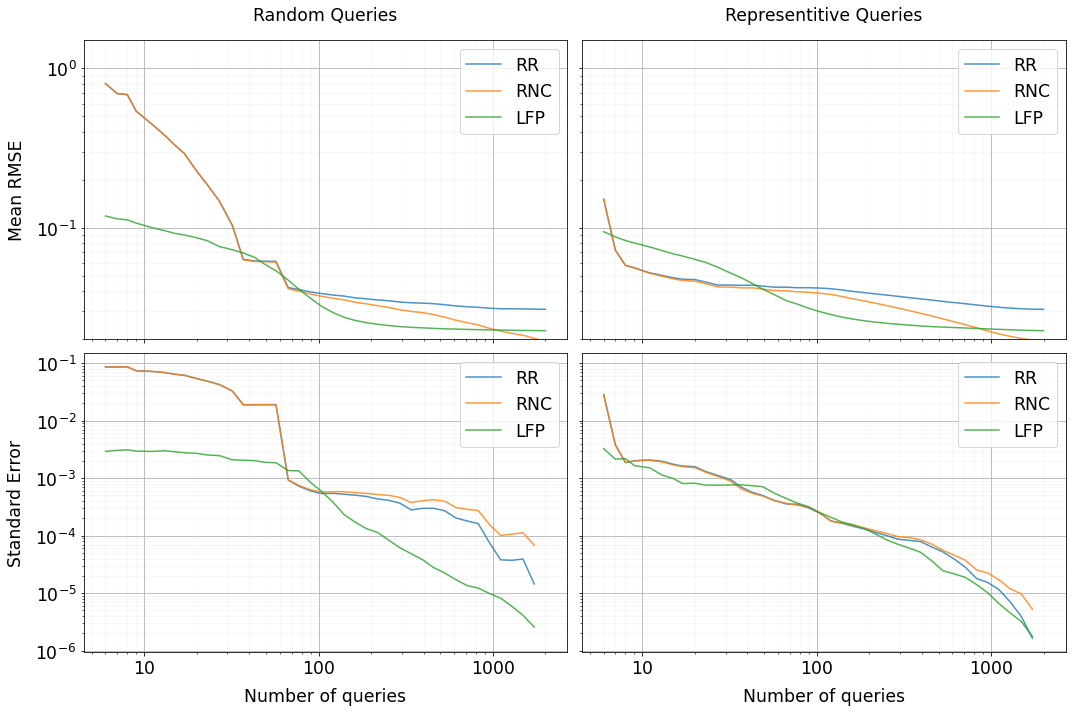

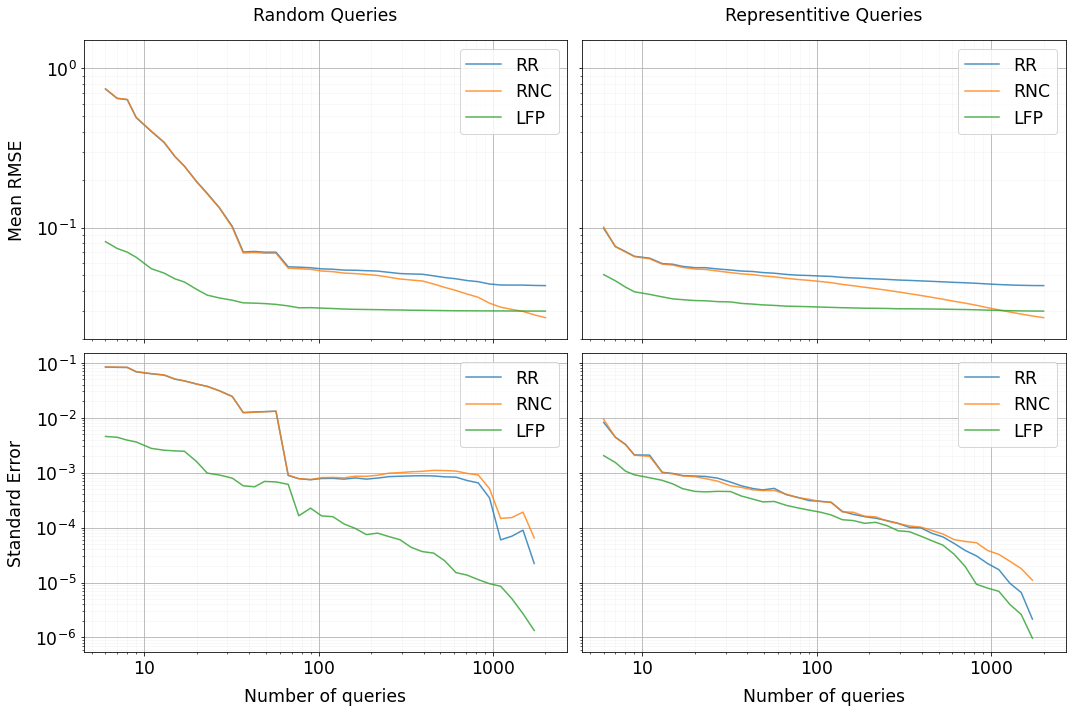

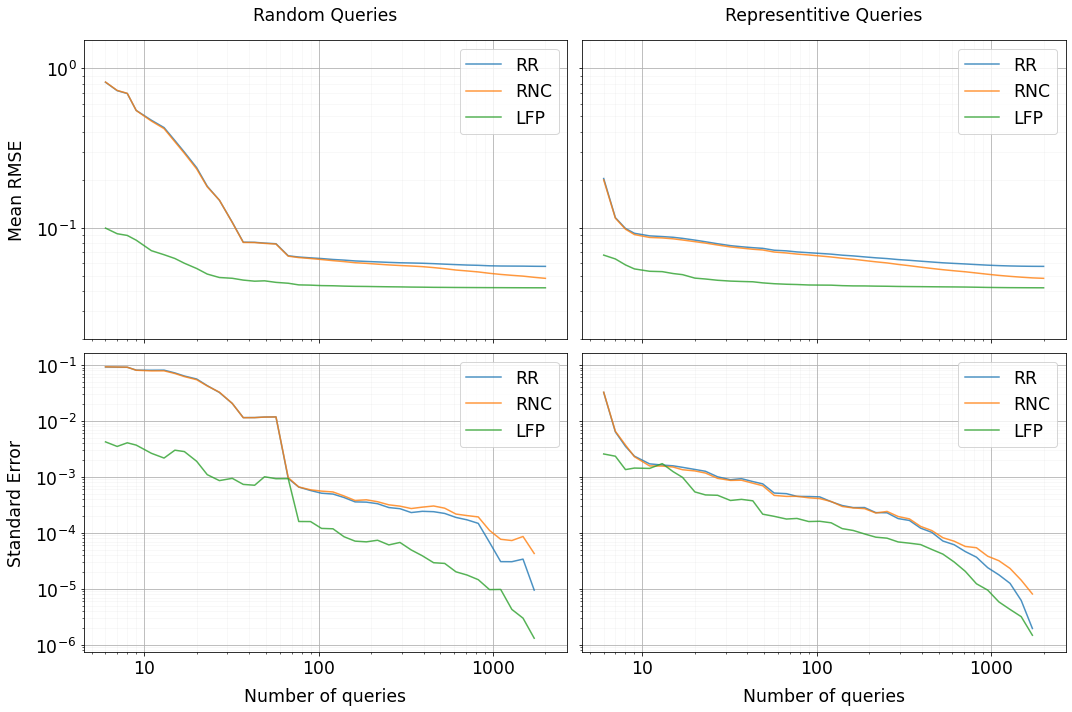

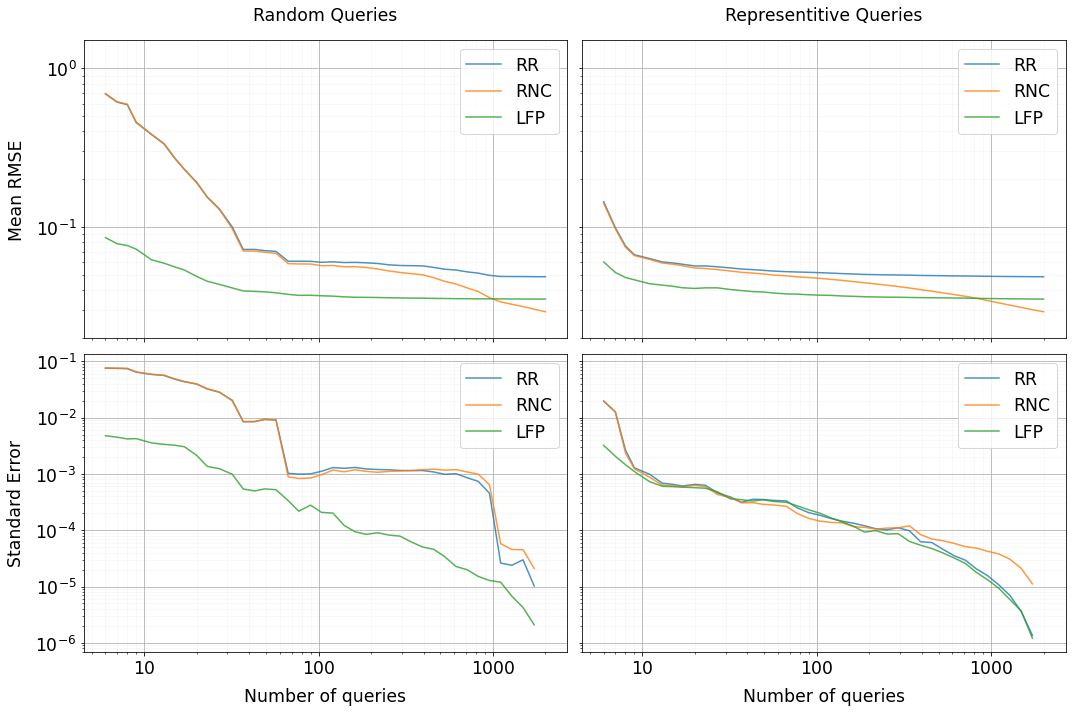

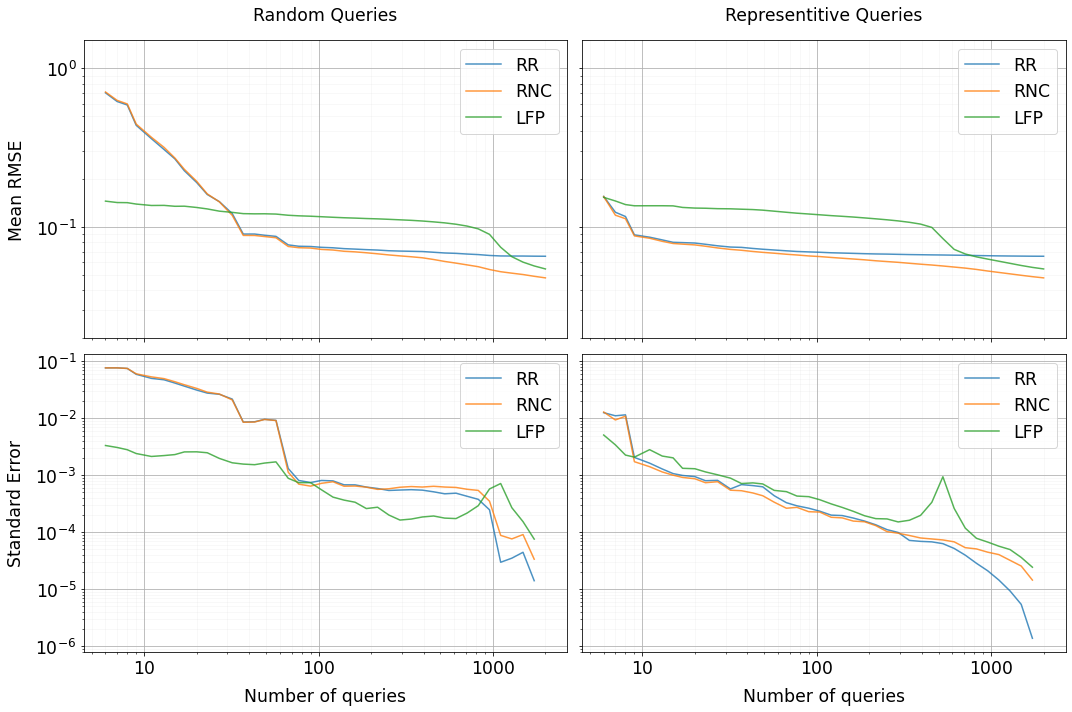

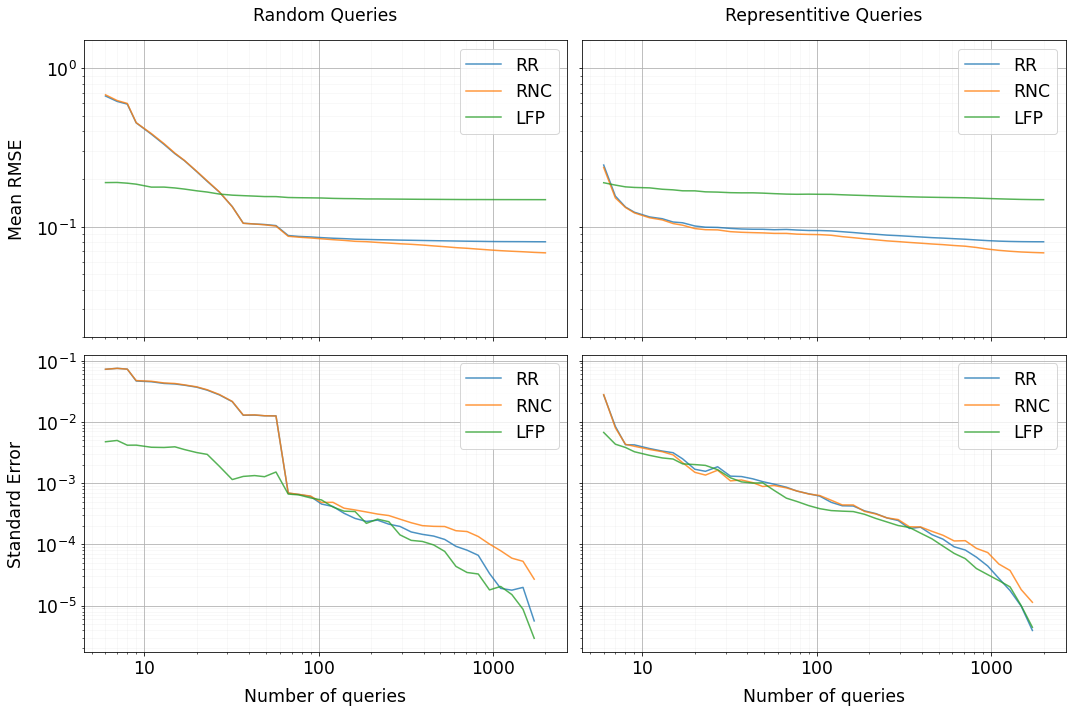

In [71]:
all_results = []

for func in ['inverse', 'exponential', 'ReLu', 'sigmoid', 'cosine', 'cut-off']:
    
    T, N, gamma, beta, eta, Y, S, S_, UT, UN, AT, AN, LT, LN, A_, J, G, Lam = generate_toy_data(N=40, T=50, gamma=1e-1, function=func)

    features = Features(G, UT, UN, S_, A_, n_clusters=10)
    
    results = compute_exp_1(0.005, 0.005, 0.001, n_q_steps, n_trials)
    all_results.append(results)
    
    
    plot_experiment1(results)


In [316]:
def compute_exp_2(lam_rr, lam_rnc, lam_lfp, q=100, n_trials=50):
    
    r_squared = {name: np.zeros(n_trials) for name in ['rr_active', 'rr_passive', 'rnc_active', 'rnc_passive', 'lfp_active', 'lfp_passive']}
    
    Omega = estimate_omega_cgm()
    
    for t in range(n_trials):

        Q_active = features.select_Q_active(q, seed=t)
        Q_passive = features.select_Q_passive(q, seed=t)

        Omega_Q_active = Omega * Q_active
        Omega_Q_passive = Omega * Q_passive

        r_squared['rr_active'][t] = RRVarSolver(Omega_Q_active, Q_active, X=features.X, lam=lam_rr).r_squared(Omega)
        r_squared['rr_passive'][t] = RRVarSolver(Omega_Q_passive, Q_passive, X=features.X, lam=lam_rr).r_squared(Omega)

        r_squared['rnc_active'][t] = RNCVarSolver(Omega_Q_active, Q_active, X=features.X, lam=lam_rnc, UT=UT, UN=UN, G=G, gamma=gamma).r_squared(Omega)
        r_squared['rnc_passive'][t] = RNCVarSolver(Omega_Q_passive, Q_passive, X=features.X, lam=lam_rnc, UT=UT, UN=UN, G=G, gamma=gamma).r_squared(Omega)

        r_squared['lfp_active'][t] = LFPVarSolver(Omega_Q_active, Q_active, X=features.X, lam=lam_rnc, UT=UT, UN=UN, Lam=Lam, S_=S_,  A_=A_, eta=eta, beta0=beta).r_squared(Omega)
        r_squared['lfp_passive'][t] = LFPVarSolver(Omega_Q_passive, Q_passive, X=features.X, lam=lam_rnc, UT=UT, UN=UN, Lam=Lam, S_=S_,  A_=A_, eta=eta, beta0=beta).r_squared(Omega)
            
    return r_squared

In [317]:

r_squared = {}

for func in ['inverse', 'exponential', 'ReLu', 'sigmoid', 'cosine', 'cut-off']:
    
    T, N, gamma, beta, eta, Y, S, S_, UT, UN, AT, AN, LT, LN, A_, J, G, Lam = generate_toy_data(N=40, T=50, gamma=1e-1, function=func)

    features = Features(G, UT, UN, S_, A_, n_clusters=10)
    
    r_squared[func] = compute_exp_2(0.005, 0.005, 0.001, q=50)
    

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

In [318]:
for func in ['inverse', 'exponential', 'ReLu', 'sigmoid', 'cosine', 'cut-off']:
    
    for sol in ['rr', 'rnc', 'lfp']:
    
        r_squared[func][f'{sol}_active'].mean()
        r_squared[func][f'{sol}_passive'].mean()

In [357]:
sols = ['rr', 'rnc', 'lfp']
funcs = ['inverse', 'exponential', 'ReLu', 'sigmoid', 'cosine']

data_active = pd.DataFrame([[r_squared[func][f'{sol}_active'].mean() for sol in sols] for func in funcs], index=[func.title() for func in funcs], columns=[sol.upper() for sol in sols])

print(data_active.round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &     RR &    RNC &    LFP \\
\midrule
Inverse     &  0.953 &  0.957 &  0.957 \\
Exponential &  0.946 &  0.951 &  0.979 \\
Relu        &  0.906 &  0.910 &  0.965 \\
Sigmoid     &  0.951 &  0.956 &  0.974 \\
Cosine      &  0.922 &  0.929 &  0.952 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_7711/424032548.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_active.round(3).to_latex())


In [356]:
sols = ['rr', 'rnc', 'lfp']
funcs = ['inverse', 'exponential', 'ReLu', 'sigmoid', 'cosine']

data_passive = pd.DataFrame([[r_squared[func][f'{sol}_passive'].mean() for sol in sols] for func in funcs], index=[func.title() for func in funcs], columns=[sol.upper() for sol in sols])

print(data_passive.round(3).to_latex())

\begin{tabular}{lrrr}
\toprule
{} &     RR &    RNC &    LFP \\
\midrule
Inverse     &  0.446 &  0.448 &  0.908 \\
Exponential &  0.737 &  0.741 &  0.978 \\
Relu        &  0.771 &  0.772 &  0.963 \\
Sigmoid     &  0.841 &  0.844 &  0.973 \\
Cosine      &  0.809 &  0.832 &  0.944 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_7711/3749428698.py:6: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(data_passive.round(3).to_latex())


<IPython.core.display.Javascript object>


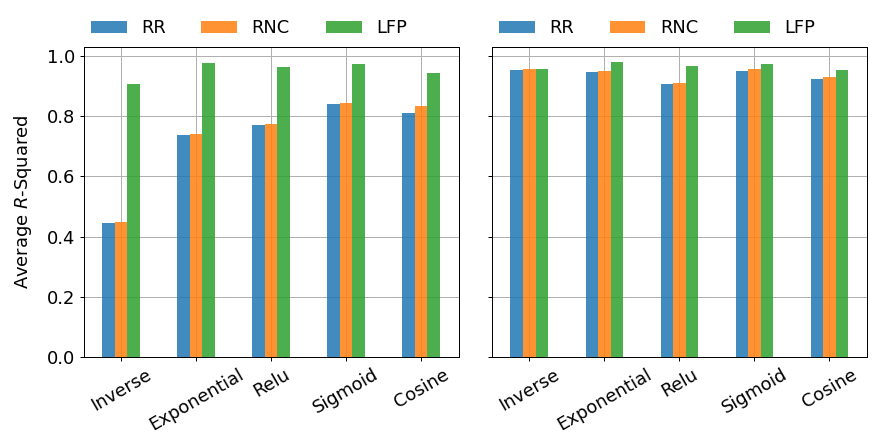

/tmp/ipykernel_7711/2434073974.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(np.round(ax.get_yticks(), 1), fontsize='x-large')


In [381]:
fig, axes = plt.subplots(ncols=2, sharey=True, figsize=(10, 5))

data_passive.plot(ax=axes[0], kind="bar", alpha=0.85)
data_active.plot(ax=axes[1], kind="bar", alpha=0.85)

for ax in axes:
    
    ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, fontsize='x-large')
    ax.set_yticklabels(np.round(ax.get_yticks(), 1), fontsize='x-large')
    ax.grid(which='major')
    ax.set_axisbelow(True)
    ax.legend(loc='lower left', bbox_to_anchor= (0.0, 1.01), ncol=3, borderaxespad=0, frameon=False, fontsize='x-large')
    
axes[0].set_ylabel('Average $R$-Squared', fontsize='x-large', labelpad=10)
    
plt.tight_layout()

plt.savefig('r-squared.pdf')

In [ ]:
fig, axes = plt.subplots()



In [281]:
pd.DataFrame(r_active, iaandex=['RR', 'RNC', 'LFP']).round(2).T

,RR,RNC,LFP
inverse,0.94,0.94,0.98
exponential,0.87,0.89,0.98
ReLu,0.85,0.87,0.96
sigmoid,0.79,0.82,0.97
cosine,0.74,0.78,0.95
cut-off,0.67,0.74,0.80


In [282]:
pd.DataFrame(r_passive, index=['RR', 'RNC', 'LFP']).round(2).T

,RR,RNC,LFP
inverse,0.95,0.96,0.99
exponential,0.89,0.90,0.98
ReLu,0.88,0.89,0.97
sigmoid,0.82,0.83,0.98
cosine,0.77,0.79,0.96
cut-off,0.71,0.75,0.73
